# BERT Model for Disaster Tweet Classification

In this Notebook, we will train a BERT model to classify tweets as disaster-related or not. We will use the preprocessed `train_data_mod.csv`, which contains the text and numerical features, to train the BERT model. <br>
We will be doing a comparison between using only `text` feature, and using `text + keyword + tweet length + punctuation count` as a combined feature. <br> This will tell us whether `text` is in fact the most important predictor, and how significant are the other features relative to the `text` feature.

- Note: Instead of using `BertForSequenceClassifier` and `Trainer` in the `transformers` library for training, we are going to implement our own Feed Foward Neural Network with the last hidden states of the BERT output to improve our model training speed. This also leaves us with customization for adding more hidden layers.

## Import the necessary Libraries

In [59]:
import torch
import numpy as np
import pandas as pd
import ast
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

## Load the Dataset

In [2]:
# Load dataset
train = pd.read_csv('../preprocessing/train_data_mod.csv')
test = pd.read_csv('../preprocessing/test_data_mod.csv')

In [3]:
train_mod = train.copy()
test_mod = test.copy()

## Examine the Dataset
- We will use the raw text instead of the preprocessed text.
- Drop the columns that we are not using.
- Count the max length of tokens in text feature to ensure that the tokenizer max_length will not truncate off remaining text data.



In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [5]:
train_mod.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'preprocess_text',
       'bigram', 'trigram', 'pos', 'keyword_encoded', 'tweet_length',
       'punctuation_count'],
      dtype='object')

In [6]:
# drop unnecessary columns
drop_cols = ['location', 'preprocess_text','bigram','trigram', 'pos', 'keyword_encoded']


In [7]:
train_mod.drop(drop_cols, axis=1, inplace=True)
test_mod.drop(drop_cols, axis=1, inplace=True)

In [8]:
train_mod.columns

Index(['id', 'keyword', 'text', 'target', 'tweet_length', 'punctuation_count'], dtype='object')

In [9]:
test_mod.columns

Index(['id', 'keyword', 'text', 'tweet_length', 'punctuation_count'], dtype='object')

In [21]:
def max_length(text_column, tokenizer):
    max_len = 0
    for text in text_column:
        tokens = tokenizer.tokenize(text)
        # print(tokens)
        max_len = max(max_len, len(tokens))
    print("Max length: ", max_len, " tokens")

In [22]:
max_length(train_mod['text'], tokenizer)
max_length(test_mod['text'], tokenizer)

Max length:  104  tokens
Max length:  99  tokens


### Concatenate `keyword`, `tweet_length` and `punctuation_count` with `text` to form a `concatenated` feature
To observe if `text` is the best predictor, we will concatenate all the features together into 1, and compare it with the `text` feature for model training later

In [10]:
def concatenate_columns(df, text_col, keyword_col, tweet_length_col, punctuation_count_col):
    df['concatenated'] = df[text_col] + ' (Keyword: ' + df[keyword_col] + ', Tweet Length: ' + df[tweet_length_col].astype(str) + ', Punctuation Count: ' + df[punctuation_count_col].astype(str) + ')'
    return df

concatenate_columns(train_mod, 'text', 'keyword', 'tweet_length', 'punctuation_count')
concatenate_columns(test_mod, 'text', 'keyword', 'tweet_length', 'punctuation_count')

,id,keyword,text,tweet_length,punctuation_count,concatenated
0,0,missing,Just happened a terrible car crash,34,0,Just happened a terrible car crash (Keyword: m...
1,2,missing,"Heard about #earthquake is different cities, s...",64,3,"Heard about #earthquake is different cities, s..."
2,3,missing,"there is a forest fire at spot pond, geese are...",96,2,"there is a forest fire at spot pond, geese are..."
3,9,missing,Apocalypse lighting. #Spokane #wildfires,40,3,Apocalypse lighting. #Spokane #wildfires (Keyw...
4,11,missing,Typhoon Soudelor kills 28 in China and Taiwan,45,0,Typhoon Soudelor kills 28 in China and Taiwan ...
...,...,...,...,...,...,...
3258,10861,missing,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,55,0,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,missing,Storm in RI worse than last hurricane. My city...,139,5,Storm in RI worse than last hurricane. My city...
3260,10868,missing,Green Line derailment in Chicago http://t.co/U...,55,5,Green Line derailment in Chicago http://t.co/U...
3261,10874,missing,MEG issues Hazardous Weather Outlook (HWO) htt...,65,7,MEG issues Hazardous Weather Outlook (HWO) htt...


In [11]:
# Check if the concatenated column is correct
train_mod['concatenated'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all (Keyword: missing, Tweet Length: 69, Punctuation Count: 1)'

In [23]:
max_length(train_mod['concatenated'], tokenizer)
max_length(test_mod['concatenated'], tokenizer)

Max length:  125  tokens
Max length:  119  tokens


## Tokenizing the `Text` and `Concatenated` feature
- Use BERT Tokenizer to get input_ids and attention mask to be used in BERT model training inputs

In [24]:
# declare tokenizer function
def tokenize(df, column, padding=True, truncation=True, max_length=135, return_tensors='pt'):
    encoded_inputs =  tokenizer(df[column].tolist(), padding=padding, truncation=truncation, max_length=max_length, return_tensors=return_tensors)
    return encoded_inputs

### `Text` Feature

In [25]:
tokenized_text_train = tokenize(train_mod, 'text')
tokenized_text_test = tokenize(test_mod, 'text')


In [26]:
input_ids_text_train = tokenized_text_train['input_ids']
attention_mask_text_train = tokenized_text_train['attention_mask']

In [27]:
input_ids_text_test = tokenized_text_test['input_ids']
attention_mask_text_test = tokenized_text_test['attention_mask']

In [28]:
print(input_ids_text_train)
print(input_ids_text_train.shape)
print(attention_mask_text_train)
print(attention_mask_text_train.shape)

tensor([[  101,  3458,  9115,  ...,     0,     0,     0],
        [  101,  4089,  1783,  ...,     0,     0,     0],
        [  101,  1398,  3159,  ...,     0,     0,     0],
        ...,
        [  101, 26528,   119,  ...,     0,     0,     0],
        [  101,  3284, 11950,  ...,     0,     0,     0],
        [  101,  1109,  6372,  ...,     0,     0,     0]])
torch.Size([7613, 106])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
torch.Size([7613, 106])


In [29]:
print(input_ids_text_test)
print(input_ids_text_test.shape)
print(attention_mask_text_test)
print(attention_mask_text_test.shape)

tensor([[  101,  2066,  2171,  ...,     0,     0,     0],
        [  101, 23599,  1164,  ...,     0,     0,     0],
        [  101,  1175,  1110,  ...,     0,     0,     0],
        ...,
        [  101,  2565,  2800,  ...,     0,     0,     0],
        [  101, 22157,  2349,  ...,     0,     0,     0],
        [  101,   108,  1392,  ...,     0,     0,     0]])
torch.Size([3263, 101])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
torch.Size([3263, 101])


### `Concatenated` Feature

In [45]:
tokenized_concatenated_train = tokenize(train_mod, 'concatenated')
tokenized_concatenated_test = tokenize(test_mod, 'concatenated')

In [47]:
input_ids_concatenated_train = tokenized_text_train['input_ids']
attention_mask_concatenated_train = tokenized_text_train['attention_mask']

In [48]:
input_ids_concatenated_test = tokenized_text_test['input_ids']
attention_mask_concatenated_test = tokenized_text_test['attention_mask']

In [49]:
print(input_ids_concatenated_train)
print(input_ids_concatenated_train.shape)
print(attention_mask_concatenated_train)
print(attention_mask_concatenated_train.shape)

tensor([[  101,  3458,  9115,  ...,     0,     0,     0],
        [  101,  4089,  1783,  ...,     0,     0,     0],
        [  101,  1398,  3159,  ...,     0,     0,     0],
        ...,
        [  101, 26528,   119,  ...,     0,     0,     0],
        [  101,  3284, 11950,  ...,     0,     0,     0],
        [  101,  1109,  6372,  ...,     0,     0,     0]])
torch.Size([7613, 106])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
torch.Size([7613, 106])


In [50]:
print(input_ids_concatenated_test)
print(input_ids_concatenated_test.shape)
print(attention_mask_concatenated_test)
print(attention_mask_concatenated_test.shape)

tensor([[  101,  2066,  2171,  ...,     0,     0,     0],
        [  101, 23599,  1164,  ...,     0,     0,     0],
        [  101,  1175,  1110,  ...,     0,     0,     0],
        ...,
        [  101,  2565,  2800,  ...,     0,     0,     0],
        [  101, 22157,  2349,  ...,     0,     0,     0],
        [  101,   108,  1392,  ...,     0,     0,     0]])
torch.Size([3263, 101])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
torch.Size([3263, 101])


### Create Helper Functions for Tensor Dataset and DataLoader

In [35]:
def create_tensor_dataset(input_ids, attention_mask):
    tensor_dataset = TensorDataset(input_ids, attention_mask)
    return tensor_dataset

In [36]:
def create_dataloader(dataset, batch_size=256):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

### `Text` Tensor Dataset and Dataloader

In [39]:
text_dataset_train = create_tensor_dataset(input_ids_text_train, attention_mask_text_train)
text_dataset_test = create_tensor_dataset(input_ids_text_test, attention_mask_text_test)
text_train_dataloader = create_dataloader(text_dataset_train)
text_test_dataloader = create_dataloader(text_dataset_test)

### `Concatenated` Tensor Dataset and Dataloader

In [51]:
cc_dataset_train = create_tensor_dataset(input_ids_concatenated_train, attention_mask_concatenated_train)
cc_dataset_test = create_tensor_dataset(input_ids_concatenated_test, attention_mask_concatenated_test)
cc_train_dataloader = create_dataloader(cc_dataset_train)
cc_test_dataloader = create_dataloader(cc_dataset_test)

## Getting the `hidden states` from BERT
- The last hidden states correspond to the text embedding of each token in the text feature.
- We will only take the hidden state of [CLS] which is the starting token, as it contains the information for the entire tweet.

In [55]:
def get_embeddings(dataloader):
    bert_model = BertModel.from_pretrained('bert-base-cased')
    bert_model.eval()

    text_embeddings = []

    with torch.no_grad():
        for batch_input_ids, batch_attention_masks in dataloader:
            outputs = bert_model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
            text_embeddings.append(batch_embeddings)

    # Concatenate all batch embeddings into a single tensor
    text_embeddings = torch.cat(text_embeddings, dim=0)
    return text_embeddings



### `Text` Hidden States

In [56]:
# Concatenate all batch embeddings into a single tensor
text_embeddings_train = get_embeddings(text_train_dataloader)
text_embeddings_test = get_embeddings(text_test_dataloader)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.w

### `Concatenated` Hidden States

In [57]:
# Concatenate all batch embeddings into a single tensor
cc_embeddings_train = get_embeddings(cc_train_dataloader)
cc_embeddings_test = get_embeddings(cc_test_dataloader)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.w

## Combined Neural Network class
- This is a simple feed foward neural network that concatenates the numerical features with the bert hidden states to be passed into the linear layer.
- More hidden layers can be added to generate a more complex Neural network

In [60]:
class CombinedModel(nn.Module):
    def __init__(self, bert_output_size, hidden_layers=[], num_classes=1):
        super(CombinedModel, self).__init__()

        # Create the hidden layers
        layers = []
        input_size = bert_output_size

        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size

        layers.append(nn.Linear(input_size, num_classes))

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

## Model Training and Evaluation
- Convert text_embeddings tensors to numpy
- Declaration of Train and Validate Function to be used inside the training loop
- To use K-Fold Cross Validation, and using the average validation accuracy as metric.

### Convert to Numpy

In [61]:
text_train = text_embeddings_train.numpy()
text_test = text_embeddings_test.numpy()
cc_train = cc_embeddings_train.numpy()
cc_test = cc_embeddings_test.numpy()
labels = train_mod['target']
labels_numpy = labels.to_numpy()

In [62]:
print(text_train)
print(text_test)
print(cc_train)
print(cc_test)
print(labels_numpy)

[[ 0.29352632 -0.0725253  -0.15692264 ... -0.06247453  0.60686743
  -0.10713238]
 [ 0.2558439   0.18093783 -0.17079301 ... -0.13905133  0.17800759
  -0.0249753 ]
 [ 0.05271018  0.02512372  0.10772833 ... -0.19850653  0.44698942
   0.07605556]
 ...
 [ 0.4800464   0.09190952  0.03730289 ... -0.36292475  0.42372495
   0.06442428]
 [ 0.37591138  0.06962702 -0.2249266  ... -0.29438037  0.10649903
  -0.06127468]
 [ 0.28238675  0.10167535 -0.27841642 ... -0.44251925  0.18965271
   0.0055821 ]]
[[ 0.38672483  0.31351298 -0.26336846 ... -0.01896451  0.03112831
  -0.16849756]
 [ 0.3826935   0.14107771  0.11714081 ... -0.21973768  0.52720225
   0.09162736]
 [ 0.34114873  0.32015327  0.05357976 ... -0.3438429  -0.06438525
  -0.21313713]
 ...
 [ 0.4840317   0.23966995 -0.13428904 ... -0.45563322  0.2540183
   0.02979453]
 [ 0.34840208 -0.03174493 -0.12533696 ... -0.31568912  0.25465614
   0.21067823]
 [ 0.33331767  0.04172427 -0.08212909 ... -0.30312482  0.37298787
   0.03889827]]
[[ 0.29352632 -0.

### Declaration of Train and Validate function


In [117]:
import torch.optim as optim
import torch.nn.functional as F

def train_and_validate(model, train_dataloader, val_dataloader, len_val_dataset, num_epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu', lr=1e-3):
    model_new = model
    model_new.to(device)

    print("Loaded Model to device")
    # Define the loss function and optimizer
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model_new.parameters(), lr=lr)
    print("Initialized Loss and Optimizer")
    for epoch in range(num_epochs):
        # Training loop
        model_new.train()
        total_loss = 0.0
        for batch_features, batch_labels in train_dataloader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model_new(batch_features)
            loss = loss_fn(logits, batch_labels)

            # Backward pass
            loss.backward()

            # Update the model parameters
            optimizer.step()

            total_loss += loss.item()

        # Print the average training loss for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_dataloader)}')

        # Validation loop
        model_new.eval()
        total_val_loss = 0.0
        correct_predictions = 0
        with torch.no_grad():
            for batch_features, batch_labels in val_dataloader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

                # Forward pass
                logits = model_new(batch_features)
                loss = loss_fn(logits, batch_labels)

                # Calculate the number of correct predictions
                # when logit is 0, mapped to sigmoid it becomes 0.5
                predictions = (logits > 0).float()
                correct_predictions += (predictions == batch_labels).sum().item()

                total_val_loss += loss.item()

        # Print the average validation loss and accuracy for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {total_val_loss / len(val_dataloader)}, Validation Accuracy: {correct_predictions / len_val_dataset}')
    return correct_predictions / len_val_dataset

### Model K-Fold Cross Validation
- Here we perform the cross validation and print the validation accuracy for each epoch
- Then the final average validation accuracy is printed after the cross validation completes.

In [88]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


In [121]:
def cross_validate(skf, text_train, labels, epochs=10, lr=1e-3, hidden_layer=[]):
    val_accuracies = []
    for train_idx, val_idx in skf.split(text_train, labels):
        # Create TensorDatasets for the current fold
        train_dataset = TensorDataset(torch.tensor(text_train[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(text_train[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

        # Create DataLoaders for the current fold
        train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=False)
        val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

        # Train and validate your model for the current fold
        # Train and validate your model for the current fold and store the validation accuracy
        model_new = CombinedModel(bert_output_size=768, hidden_layers=hidden_layer, num_classes=1)
        val_accuracy = train_and_validate(model_new, train_dataloader, val_dataloader, len(val_dataset), epochs, lr=lr)
        val_accuracies.append(val_accuracy)

    # Calculate the average validation accuracy across all folds
    average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
    print(f'Average Validation Accuracy: {average_val_accuracy}')
    return average_val_accuracy

### Cross Validate `Text` Feature

In [122]:
cross_validate(skf, text_train, labels_numpy, epochs=10, lr=1e-3)

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.6511177346110344
Epoch 1/10, Validation Loss: 0.6211113532384237, Validation Accuracy: 0.6900853578463558
Epoch 2/10, Training Loss: 0.6049139350652695
Epoch 2/10, Validation Loss: 0.590616375207901, Validation Accuracy: 0.6913985554826001
Epoch 3/10, Training Loss: 0.5791831774016222
Epoch 3/10, Validation Loss: 0.5687611997127533, Validation Accuracy: 0.7071569271175312
Epoch 4/10, Training Loss: 0.5592924964924654
Epoch 4/10, Validation Loss: 0.5537664592266083, Validation Accuracy: 0.7281680892974393
Epoch 5/10, Training Loss: 0.5444419048726559
Epoch 5/10, Validation Loss: 0.542332261800766, Validation Accuracy: 0.747866053841103
Epoch 6/10, Training Loss: 0.5326680429279804
Epoch 6/10, Validation Loss: 0.5331360151370367, Validation Accuracy: 0.7518056467498359
Epoch 7/10, Training Loss: 0.5229947753250599
Epoch 7/10, Validation Loss: 0.5256412923336029, Validation Accuracy: 0.7557452396585687
Epoc

0.7743333710093934

### Cross Validate `Concatenated` Feature

In [123]:
cross_validate(skf, cc_train, labels_numpy, epochs=10, lr=1e-3)

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.7091665069262186
Epoch 1/10, Validation Loss: 0.6372142930825552, Validation Accuracy: 0.6868023637557452
Epoch 2/10, Training Loss: 0.6164826179544131
Epoch 2/10, Validation Loss: 0.6006797850131989, Validation Accuracy: 0.7078135259356533
Epoch 3/10, Training Loss: 0.5891060878833135
Epoch 3/10, Validation Loss: 0.5801479121049246, Validation Accuracy: 0.7130663164806303
Epoch 4/10, Training Loss: 0.570223368704319
Epoch 4/10, Validation Loss: 0.5637128750483195, Validation Accuracy: 0.7261982928430729
Epoch 5/10, Training Loss: 0.5541901029646397
Epoch 5/10, Validation Loss: 0.5509748657544454, Validation Accuracy: 0.7426132632961261
Epoch 6/10, Training Loss: 0.5413138220707575
Epoch 6/10, Validation Loss: 0.5407500962416331, Validation Accuracy: 0.7537754432042022
Epoch 7/10, Training Loss: 0.5307088221112887
Epoch 7/10, Validation Loss: 0.5323781371116638, Validation Accuracy: 0.7590282337491793
Ep

0.7744646907730178

From the results, we can observe that with epoch values of 10, and a learning rate of $1e-3$, the `concatenated` feature managed to improve the validation accuracy over the `text` feature for model training by only around $0.02\%$. <br>
#### This justify that the `text` feature is the most important predictor for accurately predicting disasters from tweets.
We will try to improve the validation accuracy of the `concatenated` feature by finding the best `number of epochs` , `learning rate` and `number of hidden layers`.

### Find Optimal Epoch size
- To roughly identify a more optimal epoch rate, we will loop through different epoch sizes, and do a scatter plot

In [124]:
epochs = [i for i in range(10,55,5)]
average_val_accuracy_dict = {}
for num_epoch in epochs:
    model = CombinedModel(bert_output_size=768, num_classes=1)
    average_val_accuracy = cross_validate(skf, cc_train, labels_numpy, epochs=num_epoch, lr=1e-3)
    average_val_accuracy_dict[num_epoch] = average_val_accuracy
    print(f'Average Validation Accuracy: {average_val_accuracy}')
    print(f'Number of Epochs: {num_epoch}')


Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.6652935196955999
Epoch 1/10, Validation Loss: 0.63570636510849, Validation Accuracy: 0.6611950098489823
Epoch 2/10, Training Loss: 0.6145301113526026
Epoch 2/10, Validation Loss: 0.5975308318932852, Validation Accuracy: 0.6887721602101117
Epoch 3/10, Training Loss: 0.5847037062048912
Epoch 3/10, Validation Loss: 0.5748173892498016, Validation Accuracy: 0.706500328299409
Epoch 4/10, Training Loss: 0.5638953037559986
Epoch 4/10, Validation Loss: 0.558914989233017, Validation Accuracy: 0.7235718975705844
Epoch 5/10, Training Loss: 0.5483141553898653
Epoch 5/10, Validation Loss: 0.546511689821879, Validation Accuracy: 0.7452396585686146
Epoch 6/10, Training Loss: 0.5357875935733318
Epoch 6/10, Validation Loss: 0.53659388422966, Validation Accuracy: 0.7458962573867367
Epoch 7/10, Training Loss: 0.5255509925385317
Epoch 7/10, Validation Loss: 0.528599739074707, Validation Accuracy: 0.7511490479317138
Epoch 8/1

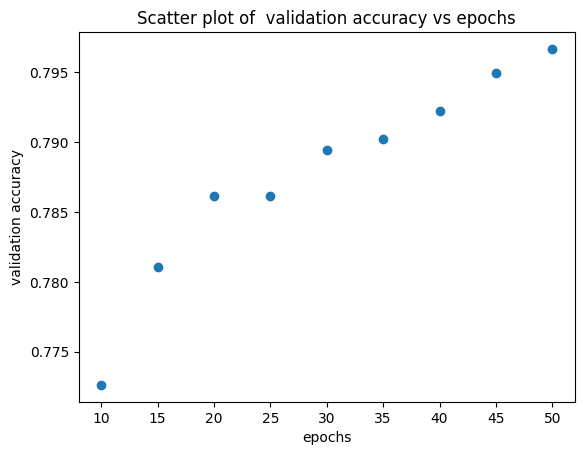

In [125]:
# Using the average_val_accuracy_dict dictionary, plot a graph with number of epochs on x-axis and average validation accuracy on y-axis
import matplotlib.pyplot as plt

# Get the keys and values as separate lists
keys = list(average_val_accuracy_dict.keys())
values = list(average_val_accuracy_dict.values())

# Create a scatter plot
plt.scatter(keys, values)

# Add labels and a title
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.title('Scatter plot of  validation accuracy vs epochs')

# Display the plot
plt.show()


Based on this graph, we can see that `epoch = 50` is the optimal parameter in the given range, and there is an increasing validation score with increasing number of epochs.  
Let's give a higher `epoch` value of `epoch = 100` to check if the validation accuracy will continue to increment or not.

In [126]:
    model = CombinedModel(bert_output_size=768, num_classes=1)
    average_val_accuracy = cross_validate(skf, cc_train, labels_numpy, epochs=100, lr=1e-3)

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/100, Training Loss: 0.6637825792034467
Epoch 1/100, Validation Loss: 0.6322039067745209, Validation Accuracy: 0.6631648063033486
Epoch 2/100, Training Loss: 0.612953670322895
Epoch 2/100, Validation Loss: 0.5946094393730164, Validation Accuracy: 0.6973079448456992
Epoch 3/100, Training Loss: 0.5836892326672872
Epoch 3/100, Validation Loss: 0.5738477011521658, Validation Accuracy: 0.7104399212081418
Epoch 4/100, Training Loss: 0.5641290086011091
Epoch 4/100, Validation Loss: 0.5585553447405497, Validation Accuracy: 0.7248850952068286
Epoch 5/100, Training Loss: 0.5489189848303795
Epoch 5/100, Validation Loss: 0.5463900764783224, Validation Accuracy: 0.7399868680236376
Epoch 6/100, Training Loss: 0.5365165919065475
Epoch 6/100, Validation Loss: 0.5366528133551279, Validation Accuracy: 0.7485226526592252
Epoch 7/100, Training Loss: 0.5263636397818724
Epoch 7/100, Validation Loss: 0.528786763548851, Validation Accuracy: 0.759028

We can observe that there isn't a significant improvement in validation accuracy when we double the epoch number to `100`.

### Find Optimal Learning Rate
Similar to finding optimal epoch, we will go through a range of learning rates, and observe if there is a relationship with validation accuracy. We will be using `epoch = 50` as our optimal epoch number.

In [127]:
lr_range = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
average_val_accuracy_dict = {}
for lr in lr_range:
    model = CombinedModel(bert_output_size=768, num_classes=1)
    average_val_accuracy = cross_validate(skf, cc_train, labels_numpy, epochs=50, lr=lr)
    average_val_accuracy_dict[lr] = average_val_accuracy
    print(f'Average Validation Accuracy: {average_val_accuracy}')
    print(f'Learning Rate: {lr}')


Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/50, Training Loss: 0.6982613081733385
Epoch 1/50, Validation Loss: 0.6967953741550446, Validation Accuracy: 0.4865397242284964
Epoch 2/50, Training Loss: 0.6955710823337237
Epoch 2/50, Validation Loss: 0.6942799687385559, Validation Accuracy: 0.5036112934996717
Epoch 3/50, Training Loss: 0.6930960069100062
Epoch 3/50, Validation Loss: 0.6919490198294321, Validation Accuracy: 0.5331582403151675
Epoch 4/50, Training Loss: 0.6908078342676163
Epoch 4/50, Validation Loss: 0.6898018717765808, Validation Accuracy: 0.5495732107682206
Epoch 5/50, Training Loss: 0.6886990542213122
Epoch 5/50, Validation Loss: 0.6878240009148916, Validation Accuracy: 0.5561391989494419
Epoch 6/50, Training Loss: 0.6867532705267271
Epoch 6/50, Validation Loss: 0.6859969794750214, Validation Accuracy: 0.5561391989494419
Epoch 7/50, Training Loss: 0.684952142337958
Epoch 7/50, Validation Loss: 0.6843026777108511, Validation Accuracy: 0.5653315824031516
Ep

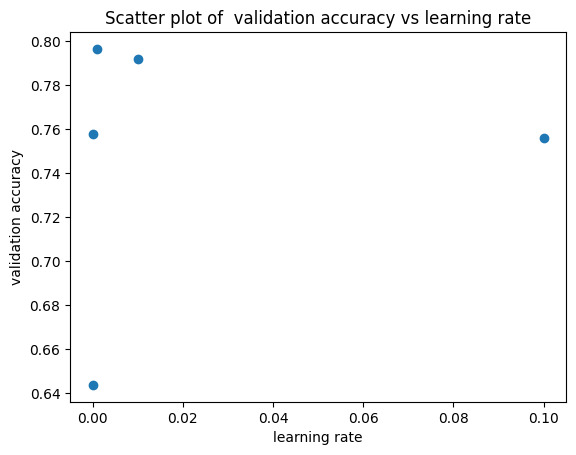

In [128]:
# Using the average_val_accuracy_dict dictionary, plot a graph with number of epochs on x-axis and average validation accuracy on y-axis
import matplotlib.pyplot as plt

# Get the keys and values as separate lists
keys = list(average_val_accuracy_dict.keys())
values = list(average_val_accuracy_dict.values())

# Create a scatter plot
plt.scatter(keys, values)

# Add labels and a title
plt.xlabel('learning rate')
plt.ylabel('validation accuracy')
plt.title('Scatter plot of  validation accuracy vs learning rate')

# Display the plot
plt.show()

We can observe that `learning rate` = $1e-3$ gave the best validation accuracy. So we will be sticking with this learning rate for our model.

### Find Optimal Number of Hidden Layers
we will go through a range of numbers of hidden layers, and observe if there is a relationship with validation accuracy. We will be using `epoch = 50` as our optimal epoch number, and `learning rate` = $1e-3$  as our optimal learning rate.

In [129]:
num_hl_range = [1, 2, 3, 4, 5]
optimal_epochs = 50
optimal_lr = 1e-3
hidden_layer_size = 768
average_val_accuracy_dict = {}
for num_hl in num_hl_range:
    average_val_accuracy = cross_validate(skf, cc_train, labels_numpy, epochs=optimal_epochs, lr=optimal_lr,hidden_layer=[hidden_layer_size for _ in range(num_hl)])
    average_val_accuracy_dict[num_hl] = average_val_accuracy
    print(f'Average Validation Accuracy: {average_val_accuracy}')
    print(f'Number of Hidden Layers: {num_hl}')

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/50, Training Loss: 0.5912760198116302
Epoch 1/50, Validation Loss: 0.536315937836965, Validation Accuracy: 0.7281680892974393
Epoch 2/50, Training Loss: 0.5060531968871752
Epoch 2/50, Validation Loss: 0.5020913332700729, Validation Accuracy: 0.7603414313854235
Epoch 3/50, Training Loss: 0.47906819730997086
Epoch 3/50, Validation Loss: 0.489495908220609, Validation Accuracy: 0.7695338148391333
Epoch 4/50, Training Loss: 0.46385641520222026
Epoch 4/50, Validation Loss: 0.4829258322715759, Validation Accuracy: 0.7774130006565988
Epoch 5/50, Training Loss: 0.4545677714049816
Epoch 5/50, Validation Loss: 0.47762472927570343, Validation Accuracy: 0.7747866053841103
Epoch 6/50, Training Loss: 0.44742808615167934
Epoch 6/50, Validation Loss: 0.47621693710486096, Validation Accuracy: 0.7747866053841103
Epoch 7/50, Training Loss: 0.44183223446210224
Epoch 7/50, Validation Loss: 0.47336170574029285, Validation Accuracy: 0.7754432042022

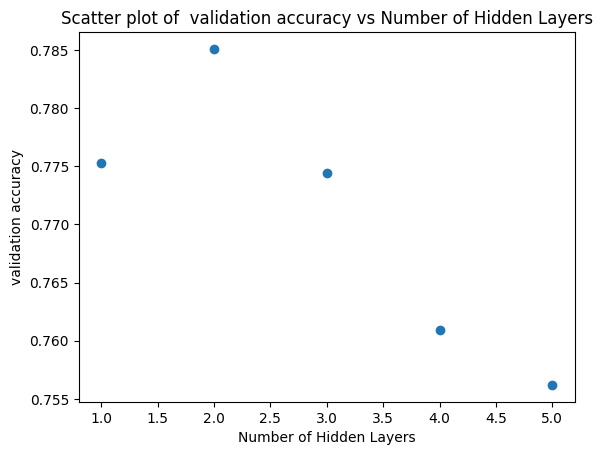

In [130]:
# Using the average_val_accuracy_dict dictionary, plot a graph with number of epochs on x-axis and average validation accuracy on y-axis
import matplotlib.pyplot as plt

# Get the keys and values as separate lists
keys = list(average_val_accuracy_dict.keys())
values = list(average_val_accuracy_dict.values())

# Create a scatter plot
plt.scatter(keys, values)

# Add labels and a title
plt.xlabel('Number of Hidden Layers')
plt.ylabel('validation accuracy')
plt.title('Scatter plot of  validation accuracy vs Number of Hidden Layers')

# Display the plot
plt.show()

In [133]:
def train(train_dataloader, num_epochs, lr, hidden_layer):
    device='cuda' if torch.cuda.is_available() else 'cpu' 
    model_new = CombinedModel(bert_output_size=768, hidden_layers=hidden_layer, num_classes=1)
    model_new.to(device)

    print("Loaded Model to device")
    # Define the loss function and optimizer
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model_new.parameters(), lr=lr)
    print("Initialized Loss and Optimizer")
    for epoch in range(num_epochs):
        # Training loop
        model_new.train()
        total_loss = 0.0
        for batch_features, batch_labels in train_dataloader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model_new(batch_features)
            loss = loss_fn(logits, batch_labels)

            # Backward pass
            loss.backward()

            # Update the model parameters
            optimizer.step()

            total_loss += loss.item()

        # Print the average training loss for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_dataloader)}')
    return model_new
    

In [136]:
optimal_epochs = 50
optimal_lr = 1e-3
optimal_num_hl = 2
hidden_layer_size = 768

# Create TensorDataset
train_dataset = TensorDataset(torch.tensor(cc_train), torch.tensor(labels_numpy.reshape(-1,1), dtype=torch.float32))

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=False)
model = train(train_dataloader, 50, 1e-3, [hidden_layer_size for _ in range(optimal_num_hl)])

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/50, Training Loss: 0.650036429365476
Epoch 2/50, Training Loss: 0.5235005666812261
Epoch 3/50, Training Loss: 0.49050375521183015
Epoch 4/50, Training Loss: 0.4732856094837189
Epoch 5/50, Training Loss: 0.4659970144430796
Epoch 6/50, Training Loss: 0.4561605354150136
Epoch 7/50, Training Loss: 0.4505796362956365
Epoch 8/50, Training Loss: 0.44457267920176186
Epoch 9/50, Training Loss: 0.43945542971293133
Epoch 10/50, Training Loss: 0.43421950340271
Epoch 11/50, Training Loss: 0.42964320878187817
Epoch 12/50, Training Loss: 0.4249780217806498
Epoch 13/50, Training Loss: 0.4196294715007146
Epoch 14/50, Training Loss: 0.41432864765326183
Epoch 15/50, Training Loss: 0.40869132181008655
Epoch 16/50, Training Loss: 0.4017115275065104
Epoch 17/50, Training Loss: 0.393517892062664
Epoch 18/50, Training Loss: 0.3851168433825175
Epoch 19/50, Training Loss: 0.37815480480591457
Epoch 20/50, Training Loss: 0.37246079991261166
Epoch 21/50

## Predict Test Set

In [143]:
def predict(model_new, test_dataloader):
    device='cuda' if torch.cuda.is_available() else 'cpu'
    model_new.eval()
    with torch.no_grad():
        for batch_features, in test_dataloader:
            batch_features = batch_features.to(device)

            # Forward pass
            logits = model_new(batch_features)
            # Calculate the number of correct predictions
            # when logit is 0, mapped to sigmoid it becomes 0.5
            predictions = (logits > 0).float()
            return predictions

In [176]:
# Create TensorDataset
test_dataset = TensorDataset(torch.tensor(cc_test))

In [182]:
# Create TensorDataset
test_dataset = TensorDataset(torch.tensor(cc_test))



# Create DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=3263, shuffle=False)
predictions = predict(model, test_dataloader)

In [185]:
# Convert the predictions tensor to integers
predictions_int = torch.round(predictions).int()

# Convert the tensor to a numpy array
predictions_np = predictions_int.cpu().numpy()

In [186]:
# Create a DataFrame
df = pd.DataFrame(predictions_np, columns=['target'])
df.head()

,target
0,1
1,1
2,1
3,1
4,1


In [187]:
df['id'] = test['id']
df.head()

,target,id
0,1,0
1,1,2
2,1,3
3,1,9
4,1,11


In [188]:
df = df[['id', 'target']]
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int32
dtypes: int32(1), int64(1)
memory usage: 38.4 KB


In [189]:
df.to_csv('BERT_predictions/BERT_CombinedNN_CC.csv', index=False)

## Conclusion

The final test prediction accuracy came out to be `0.76` which performed significantly worse than `BERT_BFSC.ipynb` and `BERT_numerical.ipynb`. This could mean that this approach of `concatenating` all the features into 1 feature and passing the BERT hidden states into a Neural Network is not well suited for the task for predicting disasters with tweets.